Acknowledgement: This project was largely motivated by the work of Michelle Lochner et al. (ApJ Supplement Series, 225:31, 2016), which can be accessed via this [link](https://iopscience.iop.org/article/10.3847/0067-0049/225/2/31).

In [5]:
# Note that this notebook was run on Google Colab,
# therefore, mounting it to Phong's Google Drive was necessary.
# If one runs it via Jupyter, this is not needed.
from google.colab import drive
drive.mount('/content/drive')

# When run locally via Jupyter, change dir to 'data/'
dir = '/content/drive/My Drive/Colab Notebooks/ML_Fall2025_Supernovae/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Step 1: Data Analysis

First, we load datasets of both models.

In [6]:
# Model 1:
I_Ia = pd.read_csv(dir + 'ML_master_table_TypeIa.csv').dropna()
I_Ibc = pd.read_csv(dir + 'ML_master_table_TypeIbc.csv').dropna()
I_II = pd.read_csv(dir + 'ML_master_table_TypeII.csv').dropna()
I_skip = ['sn_name', 'sn_type', 'band']
I_labels = ['Ia', 'Ibc', 'II']

In [7]:
# Model 2:
II_Ia = pd.read_csv(dir + 'supernova_parameters_successful[75].csv').dropna()
II_II = pd.read_csv(dir + 'supernova_parameters_successful[68].csv').dropna()
II_IIn = pd.read_csv(dir + 'supernova_parameters_successful.csv').dropna()
II_skip = {'supernova', 'type', 'band', 'n_obs', 'flux_scale', 'redshift'}
II_labels = ['Ia', 'II', 'IIn']

Next, we inspect the statistics of the features in each dataset.

In [10]:
def histogram_all(dfs, skip, labels):
    cols = [c for c in dfs[0].columns if c not in skip]

    n = len(cols)
    rows = (n + 2) // 2    # number of rows needed
    fig, axes = plt.subplots(rows, 2, figsize=(12, 3*rows))

    axes = axes.flatten()  # flatten so we can index axis[i]

    for i, column in enumerate(cols):
        ax = axes[i]

        # Plot histograms from all three datasets
        for j in range(len(dfs)):
            ax.hist(dfs[j][column], bins=30, alpha=0.5, label=labels[j])

        ax.set_xlabel(column)
        ax.set_ylabel("Count")
        ax.legend()

    # Hide unused axes if columns not multiple of 3
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

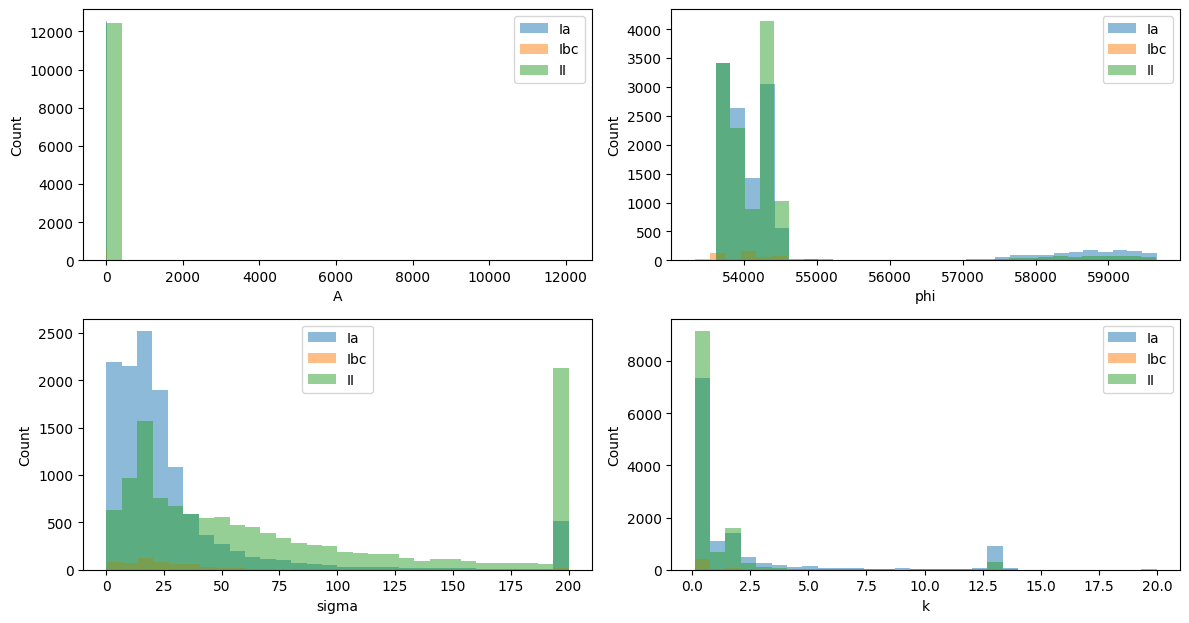

In [ ]:
# Histograms for Model 1
histogram_all([I_Ia, I_Ibc, I_II], I_skip, I_labels)

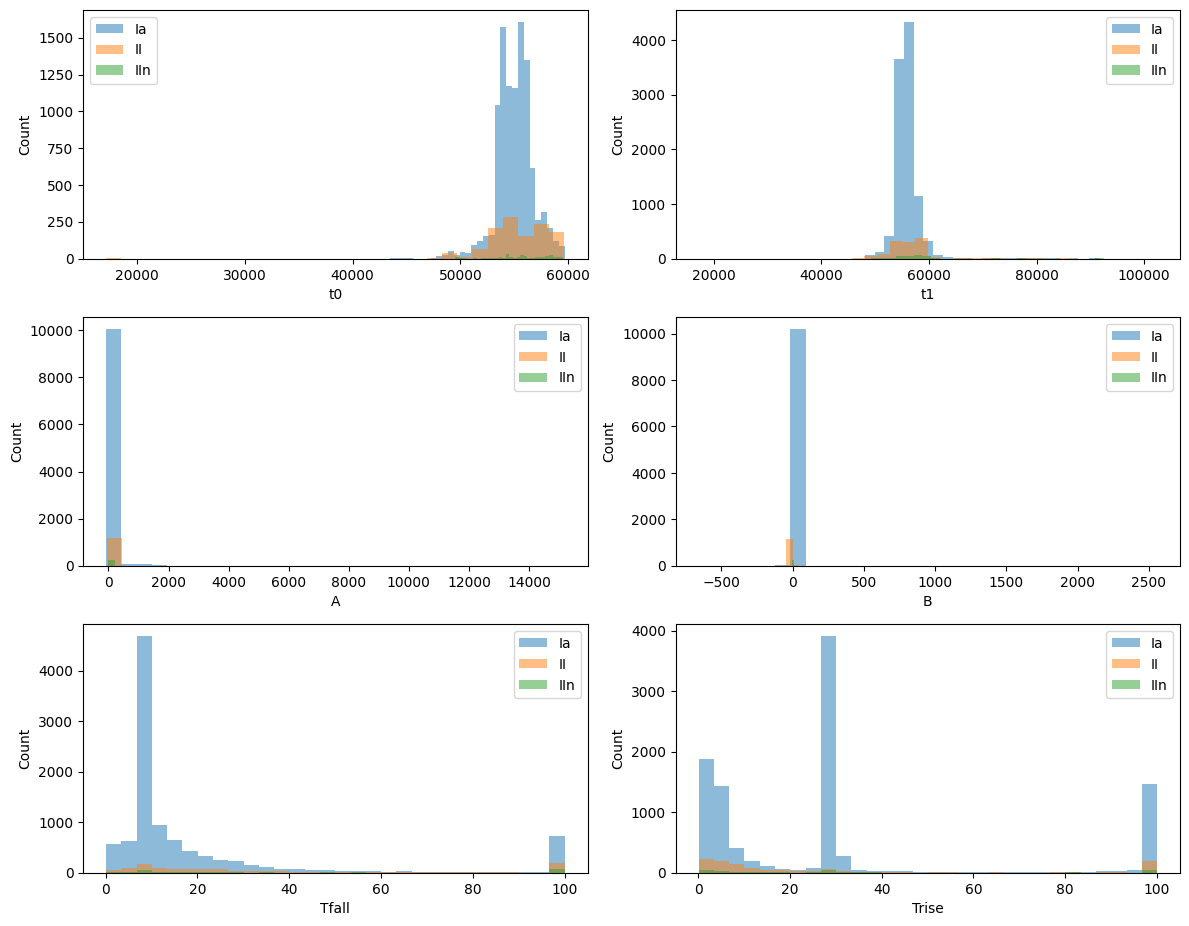

In [ ]:
# Histograms for Model 2
histogram_all([II_Ia,II_II,II_IIn],II_skip,II_labels)

Both these datasets show presence of outliers, which can skew the model. We use clipping technique to squeeze both dataset to their 25-75quantile intervals.

In [8]:
def clipping(dfs, skip):
    dfs_clipped = []
    feature_cols = [c for c in dfs[0].columns if c not in skip]

    for df in dfs:
        df_copy = df.copy()

        # Compute IQR only on feature columns
        Q1 = df_copy[feature_cols].quantile(0.25)
        Q3 = df_copy[feature_cols].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # Clip only the feature columns
        df_copy[feature_cols] = df_copy[feature_cols].clip(lower=lower, upper=upper, axis=1)

        dfs_clipped.append(df_copy)

    return dfs_clipped

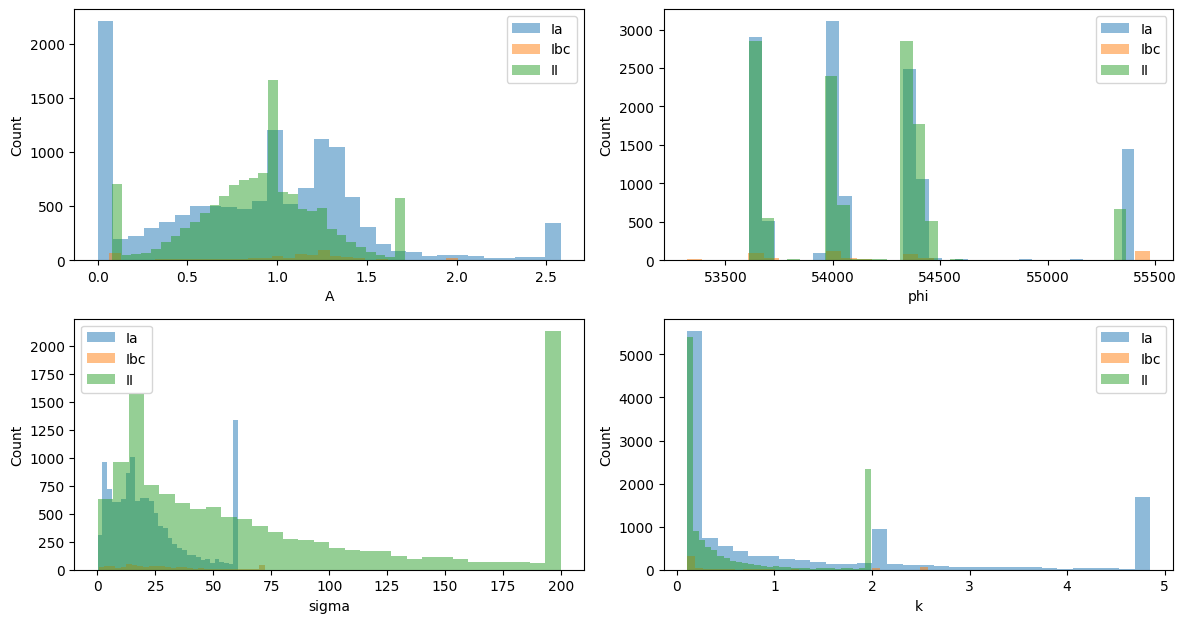

In [11]:
I_Ia_clip, I_Ibc_clip, I_II_clip = clipping([I_Ia,I_Ibc,I_II], I_skip)
histogram_all([I_Ia_clip, I_Ibc_clip, I_II_clip], I_skip, I_labels)

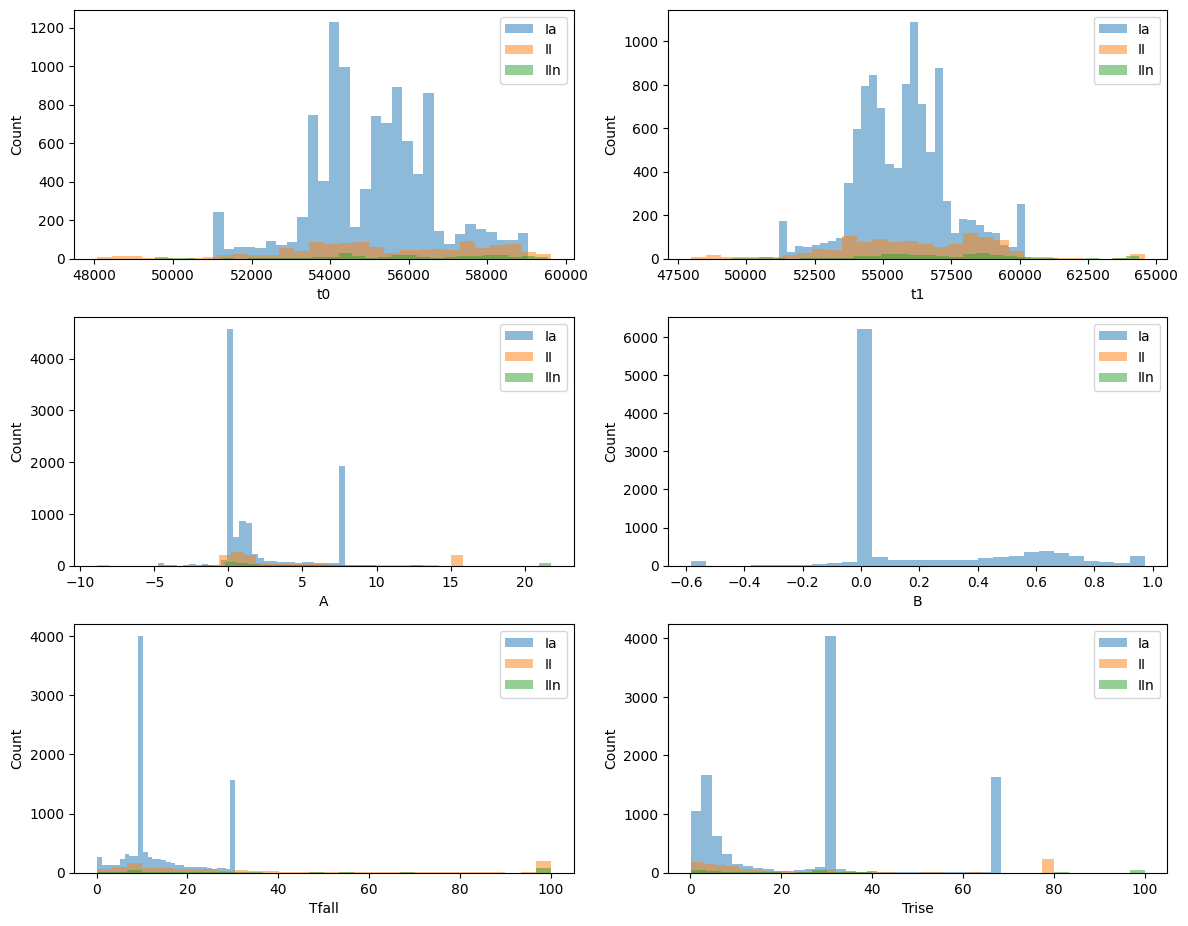

In [12]:
II_Ia_clip, II_II_clip, II_IIn_clip = clipping([II_Ia,II_II,II_IIn], II_skip)
histogram_all([II_Ia_clip, II_II_clip, II_IIn_clip], II_skip, II_labels)

Step 2: Prepare for training

In [13]:
from sklearn.preprocessing import RobustScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

First, we define a function for evaluating performance of a model.

In [84]:
def evaluate_model(model, X_train, y_train, X_test, y_test, class_names=None, history=None):
  # Print out metrics
  print("The training set:")
  y_train_pred = model.predict(X_train)
  if history is not None:
    y_train_pred = np.argmax(y_train_pred, axis=1)
  print("\n Validation accuracy: ", accuracy_score(y_train, y_train_pred))
  print("\n Classification report:\n ",classification_report(y_train, y_train_pred))
  print("\n Confusion matrix:\n", confusion_matrix(y_train, y_train_pred))

  print("\nThe test set:")
  y_test_pred = model.predict(X_test)
  if history is not None:
    y_test_pred = np.argmax(y_test_pred, axis=1)
  print("\n Validation accuracy: ", accuracy_score(y_test, y_test_pred))
  print("\n Classification report:\n ",classification_report(y_test, y_test_pred))
  print("\n Confusion matrix: \n", confusion_matrix(y_test, y_test_pred))

  # Plot ROC curve
  classes = np.unique(y_test)
  n_classes = len(classes)
  y_test_bin = label_binarize(y_test, classes=classes)
  if history is not None:
    y_score = model.predict(X_test)
  else:
    y_score = model.predict_proba(X_test)

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure(figsize=(7,6))
  colors = plt.cm.get_cmap('Set1', n_classes)
  for i in range(n_classes):
    label = f"Class {i}" if class_names is None else class_names[i]
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f'{label} (AUC = {roc_auc[i]:.2f})')

  plt.plot([0,1], [0,1], 'k--', lw=1)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multi-class ROC Curve')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show()

  # Plot XGBClassifier train/val loss if available
  if hasattr(model, "evals_result"):
    try:
      results = model.evals_result()
    except:
      results = model.get_booster().evals_result()

    # print("\nEvals result keys:", results.keys())  # debug

    # mlogloss is your eval_metric
    train_key = list(results.keys())[0]
    test_key  = list(results.keys())[1]

    metric_name = list(results[train_key].keys())[0]

    train_loss = results[train_key][metric_name]
    val_loss   = results[test_key][metric_name]

    plt.figure(figsize=(7,6))
    plt.plot(train_loss, label="Train loss")
    plt.plot(val_loss, label="Validation loss")
    plt.xlabel("Boosting Rounds")
    plt.ylabel('Loss')
    plt.title("XGBoost Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

  # Plot MLPClassifier train/val loss if available
  if history is not None:
    plt.figure(figsize=(7,6))
    plt.plot(history.history["loss"], label="Train loss")
    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("MLP Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

Second, we prepare features and labels.

In [15]:
# Model 1:
# Combining into a single dataset
I = pd.concat([I_Ia_clip, I_Ibc_clip, I_II_clip], ignore_index=True)
I = I.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
I_feature_cols = [c for c in I.columns if c not in I_skip]
I_X = I[I_feature_cols]

# Extracting labels
I_y = I['sn_type']
#print("Unique mapped labels:", I_y.unique())

# Encode categorical labels: 0 for Ia, 1 for Ibc, and 2 for II
I_name_Ia = ['Ia','IaQ','Ia_Pec']
I_name_II = ['II','II_P','IIP','IIQ','II_L','II_Pec']
I_y = I_y.apply(lambda v: 0 if v in I_name_Ia else (2 if v in I_name_II else 1))

# Split data and scale
I_X_train, I_X_test, I_y_train, I_y_test = train_test_split(
    I_X, I_y,
    test_size=0.2,
    random_state=42,
    stratify=I_y,
    shuffle=True
)

I_scaler = RobustScaler()
I_X_train = I_scaler.fit_transform(I_X_train)
I_X_test = I_scaler.transform(I_X_test)

# Count examples in classes
print("Total:\n",pd.Series(I_y).value_counts())
print("Train:\n",pd.Series(I_y_train).value_counts())
print("Test:\n",pd.Series(I_y_test).value_counts())

Total:
 sn_type
0    12590
2    12447
1      600
Name: count, dtype: int64
Train:
 sn_type
0    10072
2     9957
1      480
Name: count, dtype: int64
Test:
 sn_type
0    2518
2    2490
1     120
Name: count, dtype: int64


In [16]:
# Model 2:
# Combining into a single dataset
II = pd.concat([II_Ia_clip, II_II_clip, II_IIn_clip], ignore_index=True)
II = II.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
II_feature_cols = [c for c in II.columns if c not in II_skip]
II_X = II[II_feature_cols]

# Extracting labels
II_y = II['type']
#print("Unique mapped labels:", II_y.unique())

# Encode categorical labels
II_y = II_y.map({'Ia': 0, 'II': 1, 'IIn': 2})

# Split data and scale
II_X_train, II_X_test, II_y_train, II_y_test = train_test_split(
    II_X, II_y,
    test_size=0.2,
    random_state=42,
    stratify=II_y,
    shuffle=True
)

II_scaler = RobustScaler()
II_X_train = II_scaler.fit_transform(II_X_train)
II_X_test = II_scaler.transform(II_X_test)

# Count examples in classes
print("Total:\n",pd.Series(II_y).value_counts())
print("Train:\n",pd.Series(II_y_train).value_counts())
print("Test:\n",pd.Series(II_y_test).value_counts())

Total:
 type
0    10234
1     1174
2      255
Name: count, dtype: int64
Train:
 type
0    8187
1     939
2     204
Name: count, dtype: int64
Test:
 type
0    2047
1     235
2      51
Name: count, dtype: int64


It can be seen that both datasets have very strong imbalance between classes. We try downsampling.

In [17]:
# Model 1:
# Combining into a single dataset
I_down = pd.concat([I_Ia_clip.sample(1000), I_Ibc_clip, I_II_clip.sample(1000)], ignore_index=True)
I_down = I_down.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
I_X_down = I_down[I_feature_cols]

# Extracting labels
I_y_down = I_down['sn_type']
#print("Unique mapped labels:", I_y_down.unique())

# Encode categorical labels: 0 for Ia, 1 for Ibc, and 2 for II
I_y_down = I_y_down.apply(lambda v: 0 if v in I_name_Ia else (2 if v in I_name_II else 1))

# Split data and scale
I_X_train_down, I_X_test_down, I_y_train_down, I_y_test_down = train_test_split(
    I_X_down, I_y_down,
    test_size=0.2,
    random_state=42,
    stratify=I_y_down,
    shuffle=True
)

I_scaler_down = RobustScaler()
I_X_train_down = I_scaler_down.fit_transform(I_X_train_down)
I_X_test_down = I_scaler_down.transform(I_X_test_down)

# Count examples in classes
print("Total:\n",pd.Series(I_y_down).value_counts())
print("Train:\n",pd.Series(I_y_train_down).value_counts())
print("Test:\n",pd.Series(I_y_test_down).value_counts())

Total:
 sn_type
0    1000
2    1000
1     600
Name: count, dtype: int64
Train:
 sn_type
0    800
2    800
1    480
Name: count, dtype: int64
Test:
 sn_type
2    200
0    200
1    120
Name: count, dtype: int64


In [18]:
# Model 2:
# Combining into a single dataset
II_down = pd.concat([II_Ia_clip.sample(2000), II_II_clip, II_IIn_clip], ignore_index=True)
II_down = II_down.sample(frac=1, random_state=42).reset_index(drop=True)

# Extracting features
II_X_down = II_down[II_feature_cols]

# Extracting labels
II_y_down = II_down['type']
#print("Unique mapped labels:", II_y.unique())

# Encode categorical labels
II_y_down = II_y_down.map({'Ia': 0, 'II': 1, 'IIn': 2})

# Split data and scale
II_X_train_down, II_X_test_down, II_y_train_down, II_y_test_down = train_test_split(
    II_X_down, II_y_down,
    test_size=0.2,
    random_state=42,
    stratify=II_y_down,
    shuffle=True
)

II_scaler_down = RobustScaler()
II_X_train_down = II_scaler_down.fit_transform(II_X_train_down)
II_X_test_down = II_scaler_down.transform(II_X_test_down)

# Count examples in classes
print("Total:\n",pd.Series(II_y_down).value_counts())
print("Train:\n",pd.Series(II_y_train_down).value_counts())
print("Test:\n",pd.Series(II_y_test_down).value_counts())

Total:
 type
0    2000
1    1174
2     255
Name: count, dtype: int64
Train:
 type
0    1600
1     939
2     204
Name: count, dtype: int64
Test:
 type
0    400
1    235
2     51
Name: count, dtype: int64


Step 3: Multi-layer perceptron classifier

In [75]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6970 - loss: 0.6468 - val_accuracy: 0.7724 - val_loss: 0.5209
Epoch 2/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7627 - loss: 0.5302 - val_accuracy: 0.7898 - val_loss: 0.4910
Epoch 3/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7702 - loss: 0.5045 - val_accuracy: 0.7999 - val_loss: 0.4731
Epoch 4/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7883 - loss: 0.4802 - val_accuracy: 0.7966 - val_loss: 0.4631
Epoch 5/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7871 - loss: 0.4695 - val_accuracy: 0.8048 - val_loss: 0.4516
Epoch 6/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8009 - loss: 0.4593 - val_accuracy: 0.8087 - val_loss: 0.4434
Epoch 7/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8009 - loss: 0.4580 - val_accuracy: 0.8099 - val_loss: 0.4400
Epoch 8/50
641/641 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7992 - loss: 0.4495 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/tmp/ipython-input-3757167192.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


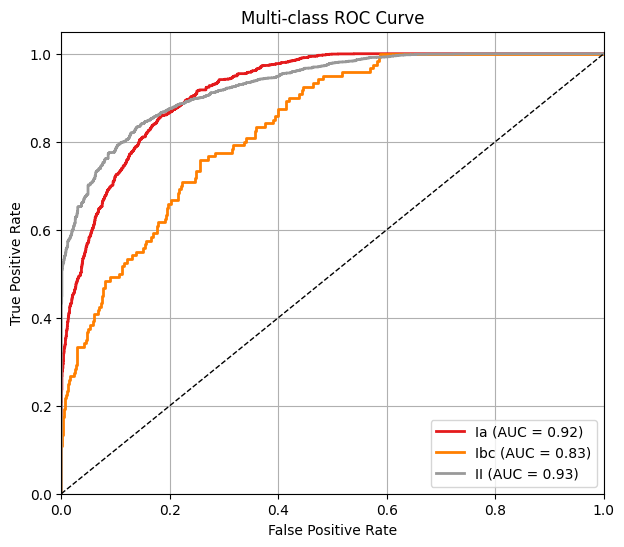

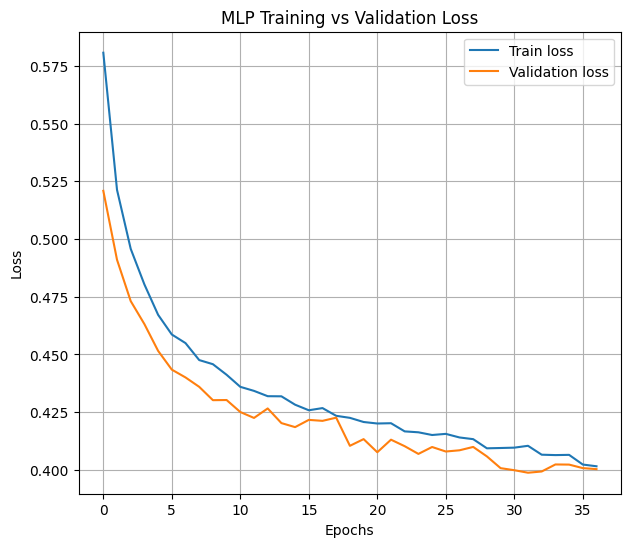

In [95]:
# Model 1 without downsampling
I_mlp = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(4,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(3, activation='softmax')
])

I_mlp.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

I_history = I_mlp.fit(
    I_X_train, I_y_train,
    validation_data=(I_X_test, I_y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

evaluate_model(I_mlp, I_X_train, I_y_train, I_X_test, I_y_test, I_labels, I_history)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5406 - loss: 0.9546 - val_accuracy: 0.5673 - val_loss: 0.8644
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5596 - loss: 0.8726 - val_accuracy: 0.5596 - val_loss: 0.8390
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5726 - loss: 0.8510 - val_accuracy: 0.5712 - val_loss: 0.8209
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5590 - loss: 0.8401 - val_accuracy: 0.6096 - val_loss: 0.8036
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5974 - loss: 0.8076 - val_accuracy: 0.6288 - val_loss: 0.7902
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6151 - loss: 0.8156 - val_accuracy: 0.6250 - val_loss: 0.7837
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6306 - loss: 0.7983 - val_accuracy: 0.6423 - val_loss: 0.7719
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6349 - loss: 0.7859 - val_accuracy: 0.6365 - val_loss: 0.7684
E

/tmp/ipython-input-3757167192.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


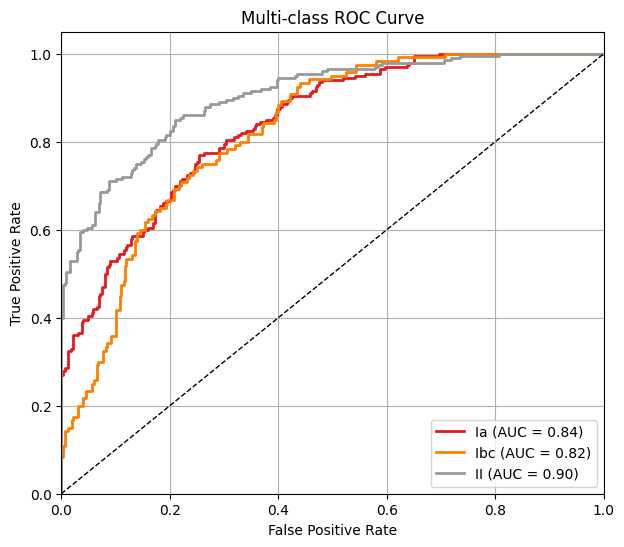

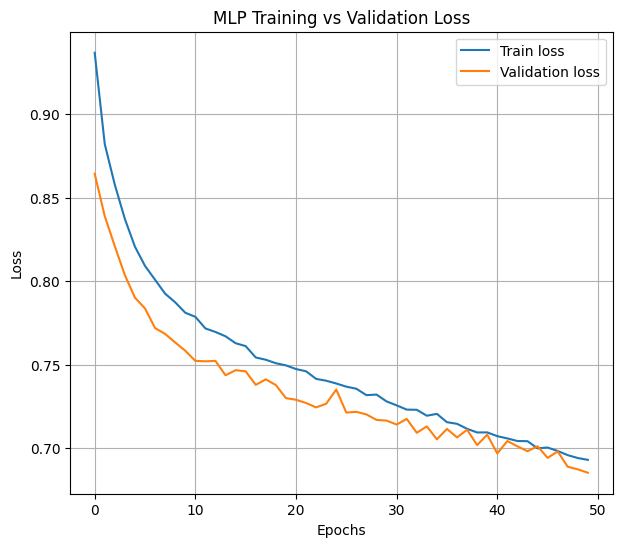

In [99]:
# Model 1 with downsampling
I_mlp_down = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(4,)),
    layers.Dense(32, activation='relu'),
    #layers.Dropout(0.4),
    layers.Dense(3, activation='softmax')
])

I_mlp_down.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

I_history_down = I_mlp_down.fit(
    I_X_train_down, I_y_train_down,
    validation_data=(I_X_test_down, I_y_test_down),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

evaluate_model(I_mlp_down, I_X_train_down, I_y_train_down, I_X_test_down, I_y_test_down, I_labels, I_history_down)

In [ ]:
# Model 2 without downsampling
II_mlp = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(6,)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(3, activation='softmax')
])

II_mlp.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

II_history = II_mlp.fit(
    II_X_train, II_y_train,
    validation_data=(II_X_test, II_y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

evaluate_model(II_mlp, II_X_train, II_y_train, II_X_test, II_y_test, II_labels, II_history)

Iteration 1, loss = 0.68134854
Validation score: 0.712727
Iteration 2, loss = 0.57705154
Validation score: 0.720000
Iteration 3, loss = 0.54038852
Validation score: 0.745455
Iteration 4, loss = 0.51230482
Validation score: 0.774545
Iteration 5, loss = 0.49824582
Validation score: 0.781818
Iteration 6, loss = 0.47675317
Validation score: 0.814545
Iteration 7, loss = 0.46384041
Validation score: 0.810909
Iteration 8, loss = 0.45061446
Validation score: 0.814545
Iteration 9, loss = 0.44113553
Validation score: 0.825455
Iteration 10, loss = 0.43168749
Validation score: 0.825455
Iteration 11, loss = 0.42531747
Validation score: 0.836364
Iteration 12, loss = 0.41519083
Validation score: 0.832727
Iteration 13, loss = 0.40751444
Validation score: 0.836364
Iteration 14, loss = 0.40413533
Validation score: 0.840000
Iteration 15, loss = 0.39495432
Validation score: 0.832727
Iteration 16, loss = 0.39036270
Validation score: 0.836364
Iteration 17, loss = 0.38585994
Validation score: 0.847273
Iterat

/tmp/ipython-input-309817868.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


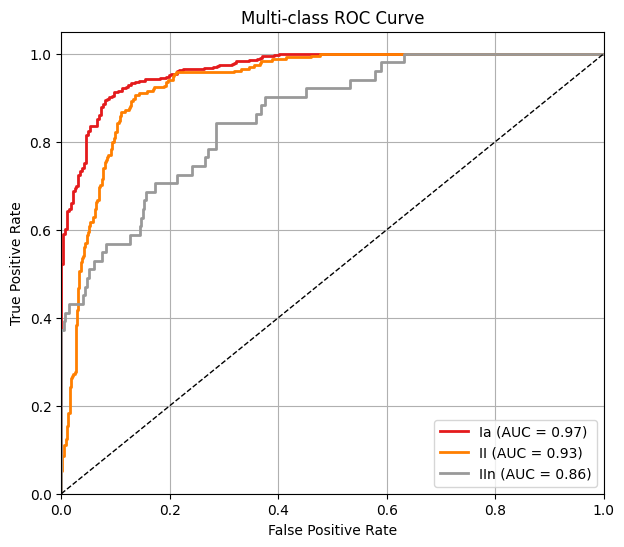

In [ ]:
# Model 2 with downsampling
II_mlp_down = MLPClassifier(
    hidden_layer_sizes=(128,64),
    activation='relu',
    alpha=0.001,
    batch_size=32,
    learning_rate='adaptive',
    max_iter=500,
    shuffle=True,
    verbose=True,
    early_stopping=True,
    validation_fraction=0.1
)

II_mlp_down.fit(II_X_train_down, II_y_train_down)
evaluate_model(II_mlp_down, II_X_train_down, II_y_train_down, II_X_test_down, II_y_test_down, II_labels)

Observation: Model 2 outperforms Model 1 with or without downsampling. Downsampling makes it worse for the classifier.

Step 4: Support vector machine classifier

In [ ]:
from sklearn.svm import SVC

The training set:

 Validation accuracy:  0.6243600370569018

 Classification report:
                precision    recall  f1-score   support

           0       0.74      0.60      0.66     10072
           1       0.07      0.71      0.12       480
           2       0.87      0.65      0.74      9957

    accuracy                           0.62     20509
   macro avg       0.56      0.65      0.51     20509
weighted avg       0.79      0.62      0.69     20509


 Confusion matrix:
 [[6024 3151  897]
 [  89  342   49]
 [1999 1519 6439]]

The test set:

 Validation accuracy:  0.6281201248049922

 Classification report:
                precision    recall  f1-score   support

           0       0.75      0.61      0.67      2518
           1       0.06      0.66      0.12       120
           2       0.87      0.64      0.74      2490

    accuracy                           0.63      5128
   macro avg       0.56      0.64      0.51      5128
weighted avg       0.79      0.63      0.69 

/tmp/ipython-input-309817868.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


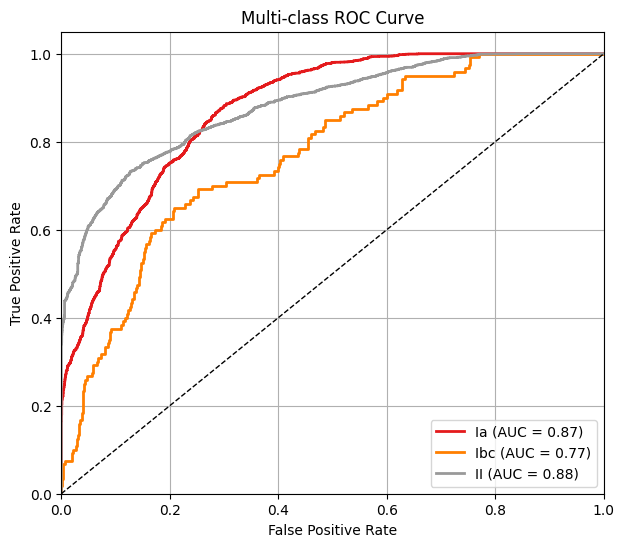

In [ ]:
# Model 1 without downsampling
I_svm = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True)

I_svm.fit(I_X_train, I_y_train)
evaluate_model(I_svm, I_X_train, I_y_train, I_X_test, I_y_test, I_labels)

The training set:

 Validation accuracy:  0.6

 Classification report:
                precision    recall  f1-score   support

           0       0.62      0.51      0.55       800
           1       0.43      0.69      0.53       480
           2       0.77      0.64      0.70       800

    accuracy                           0.60      2080
   macro avg       0.61      0.61      0.60      2080
weighted avg       0.63      0.60      0.61      2080


 Confusion matrix:
 [[404 303  93]
 [ 94 329  57]
 [158 127 515]]

The test set:

 Validation accuracy:  0.6115384615384616

 Classification report:
                precision    recall  f1-score   support

           0       0.66      0.46      0.54       200
           1       0.42      0.69      0.52       120
           2       0.78      0.71      0.74       200

    accuracy                           0.61       520
   macro avg       0.62      0.62      0.60       520
weighted avg       0.65      0.61      0.62       520


 Confusion m

/tmp/ipython-input-309817868.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


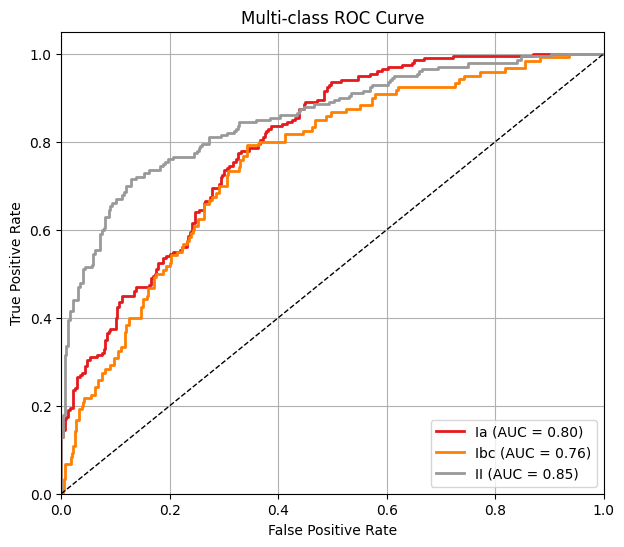

In [ ]:
# Model 1 with downsampling
I_svm_down = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True)

I_svm_down.fit(I_X_train_down, I_y_train_down)
evaluate_model(I_svm_down, I_X_train_down, I_y_train_down, I_X_test_down, I_y_test_down, I_labels)

The training set:

 Validation accuracy:  0.8404072883172562

 Classification report:
                precision    recall  f1-score   support

           0       0.97      0.87      0.92      8187
           1       0.50      0.58      0.54       939
           2       0.18      0.75      0.29       204

    accuracy                           0.84      9330
   macro avg       0.55      0.74      0.58      9330
weighted avg       0.90      0.84      0.87      9330


 Confusion matrix:
 [[7144  522  521]
 [ 213  543  183]
 [  25   25  154]]

The test set:

 Validation accuracy:  0.833690527218174

 Classification report:
                precision    recall  f1-score   support

           0       0.97      0.87      0.92      2047
           1       0.50      0.59      0.54       235
           2       0.11      0.47      0.18        51

    accuracy                           0.83      2333
   macro avg       0.53      0.64      0.55      2333
weighted avg       0.90      0.83      0.86  

/tmp/ipython-input-309817868.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


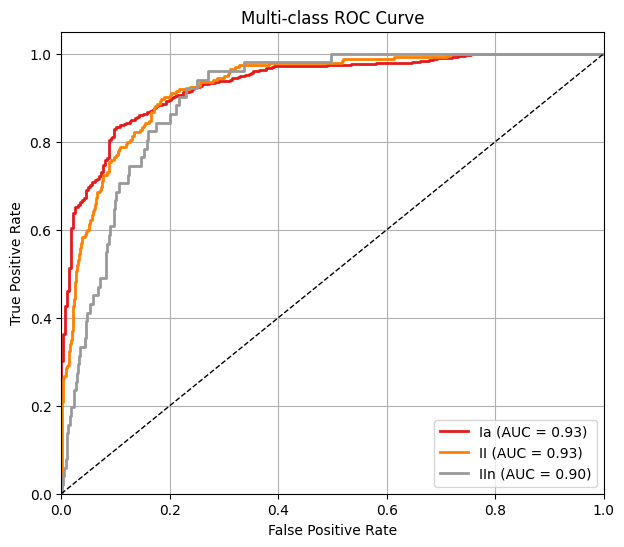

In [ ]:
# Model 2 without downsampling
II_svm = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True)

II_svm.fit(II_X_train, II_y_train)
evaluate_model(II_svm, II_X_train, II_y_train, II_X_test, II_y_test, II_labels)

The training set:

 Validation accuracy:  0.5585125774699234

 Classification report:
                precision    recall  f1-score   support

           0       1.00      0.37      0.54      1600
           1       0.44      1.00      0.61       939
           2       0.00      0.00      0.00       204

    accuracy                           0.56      2743
   macro avg       0.48      0.46      0.38      2743
weighted avg       0.73      0.56      0.52      2743


 Confusion matrix:
 [[ 593 1007    0]
 [   0  939    0]
 [   0  204    0]]

The test set:

 Validation accuracy:  0.5612244897959183

 Classification report:
                precision    recall  f1-score   support

           0       1.00      0.38      0.55       400
           1       0.44      1.00      0.61       235
           2       0.00      0.00      0.00        51

    accuracy                           0.56       686
   macro avg       0.48      0.46      0.39       686
weighted avg       0.73      0.56      0.53 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

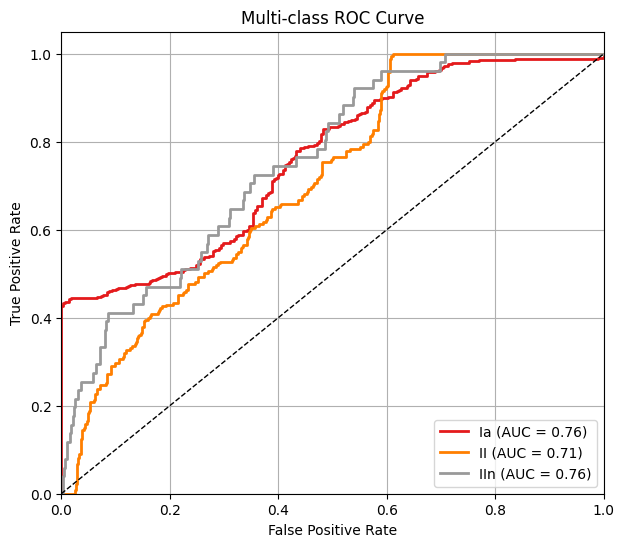

In [ ]:
# Model 2 with downsampling
II_svm_down = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', probability=True)

II_svm_down.fit(II_X_train_down, II_y_train_down)
evaluate_model(II_svm_down, II_X_train_down, II_y_train_down, II_X_test_down, II_y_test_down, II_labels)

Observation: Model 2 outperforms Model 1 without downsampling. Downsampling makes it worse for the classifier.

Step 5: Boosted decision tree classifier

In [20]:
from xgboost import XGBClassifier

The training set:

 Validation accuracy:  0.8585499049197913

 Classification report:
                precision    recall  f1-score   support

           0       0.82      0.92      0.87     10072
           1       0.98      0.32      0.48       480
           2       0.91      0.82      0.86      9957

    accuracy                           0.86     20509
   macro avg       0.90      0.69      0.74     20509
weighted avg       0.86      0.86      0.86     20509


 Confusion matrix:
 [[9283    3  786]
 [ 259  153   68]
 [1785    0 8172]]

The test set:

 Validation accuracy:  0.8627145085803433

 Classification report:
                precision    recall  f1-score   support

           0       0.82      0.93      0.87      2518
           1       1.00      0.31      0.47       120
           2       0.92      0.82      0.86      2490

    accuracy                           0.86      5128
   macro avg       0.91      0.69      0.74      5128
weighted avg       0.87      0.86      0.86 

/tmp/ipython-input-3757167192.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


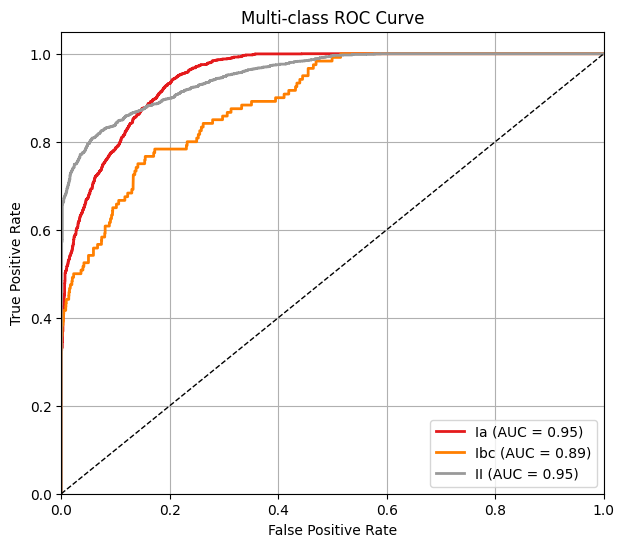

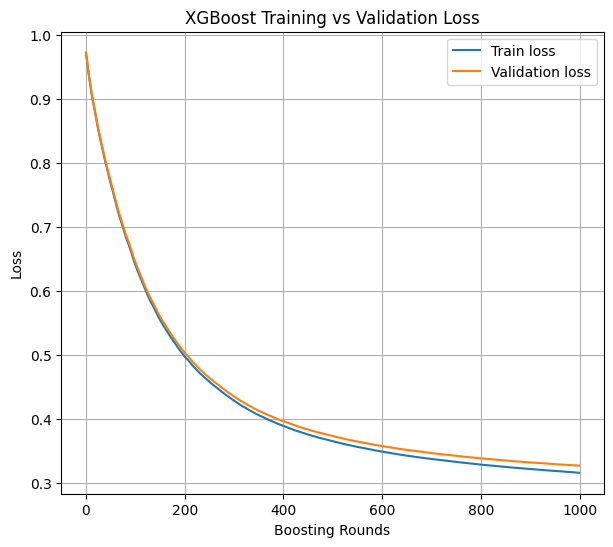

In [100]:
# Model 1 without downsampling
I_bdt = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=3,
    subsample=0.7,
    colsample_bytree=0.7,
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    early_stopping_rounds=5
)

I_bdt.fit(I_X_train, I_y_train,
          eval_set=[(I_X_train, I_y_train),(I_X_test, I_y_test)],
          verbose=False)
evaluate_model(I_bdt, I_X_train, I_y_train, I_X_test, I_y_test, I_labels)

The training set:

 Validation accuracy:  0.7644230769230769

 Classification report:
                precision    recall  f1-score   support

           0       0.65      0.94      0.77       800
           1       0.92      0.45      0.61       480
           2       0.91      0.77      0.83       800

    accuracy                           0.76      2080
   macro avg       0.83      0.72      0.74      2080
weighted avg       0.81      0.76      0.76      2080


 Confusion matrix:
 [[755  13  32]
 [230 218  32]
 [178   5 617]]

The test set:

 Validation accuracy:  0.7615384615384615

 Classification report:
                precision    recall  f1-score   support

           0       0.66      0.94      0.78       200
           1       0.88      0.42      0.56       120
           2       0.88      0.79      0.83       200

    accuracy                           0.76       520
   macro avg       0.81      0.72      0.73       520
weighted avg       0.80      0.76      0.75       520

/tmp/ipython-input-3757167192.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


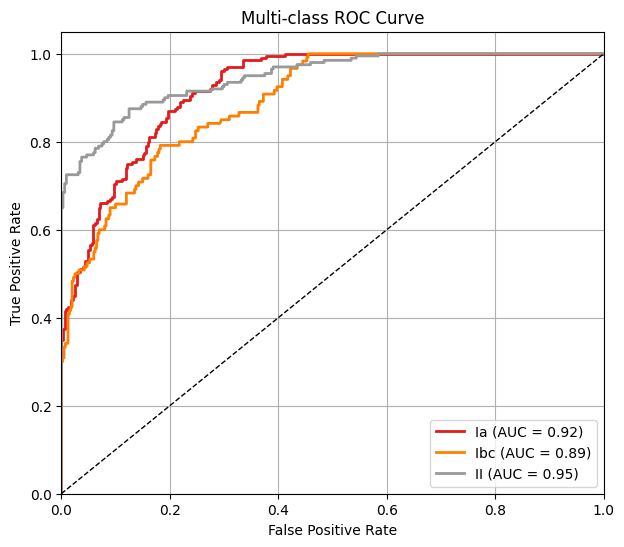

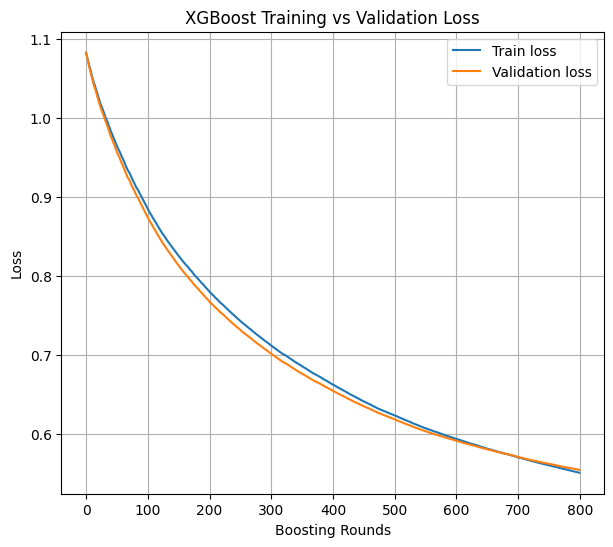

In [101]:
# Model 1 with downsampling
I_bdt_down = XGBClassifier(
    n_estimators=800,
    learning_rate=0.01,
    max_depth=2,
    subsample=0.7,
    colsample_bytree=0.7,
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    early_stopping_rounds=5
)

I_bdt_down.fit(I_X_train_down, I_y_train_down,
               eval_set=[(I_X_train_down, I_y_train_down),(I_X_test_down, I_y_test_down)],
               verbose=False)
evaluate_model(I_bdt_down, I_X_train_down, I_y_train_down, I_X_test_down, I_y_test_down, I_labels)

The training set:

 Validation accuracy:  0.9490889603429796

 Classification report:
                precision    recall  f1-score   support

           0       0.95      1.00      0.98      8187
           1       0.88      0.65      0.75       939
           2       0.97      0.38      0.54       204

    accuracy                           0.95      9330
   macro avg       0.94      0.68      0.76      9330
weighted avg       0.95      0.95      0.94      9330


 Confusion matrix:
 [[8166   19    2]
 [ 327  612    0]
 [  61   66   77]]

The test set:

 Validation accuracy:  0.949849978568367

 Classification report:
                precision    recall  f1-score   support

           0       0.96      1.00      0.98      2047
           1       0.87      0.67      0.75       235
           2       0.94      0.33      0.49        51

    accuracy                           0.95      2333
   macro avg       0.92      0.67      0.74      2333
weighted avg       0.95      0.95      0.94  

/tmp/ipython-input-3757167192.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


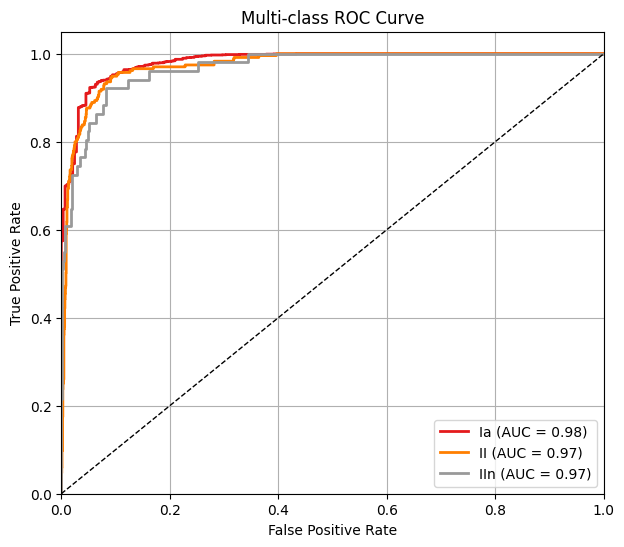

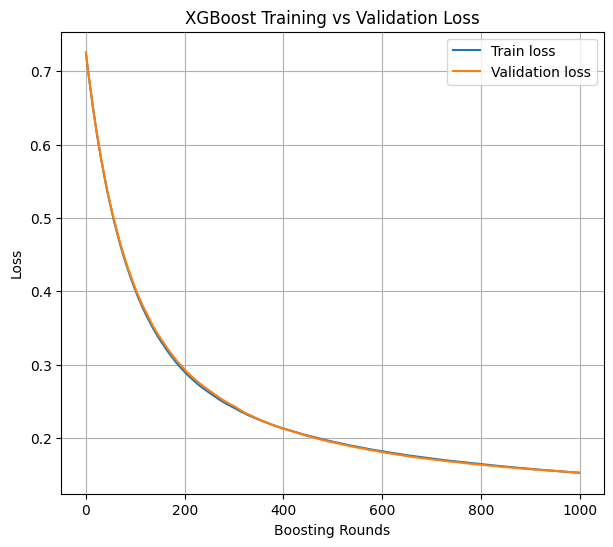

In [102]:
# Model 2 without downsampling
II_bdt = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=2,
    min_child_weight=3,
    subsample=0.7,
    colsample_bytree=0.7,
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    early_stopping_rounds=5
)

II_bdt.fit(II_X_train, II_y_train,
           eval_set=[(II_X_train, II_y_train),(II_X_test, II_y_test)],
           verbose=False)
evaluate_model(II_bdt, II_X_train, II_y_train, II_X_test, II_y_test, II_labels)

The training set:

 Validation accuracy:  0.7921983230040102

 Classification report:
                precision    recall  f1-score   support

           0       0.76      1.00      0.86      1600
           1       0.89      0.56      0.69       939
           2       1.00      0.25      0.39       204

    accuracy                           0.79      2743
   macro avg       0.88      0.60      0.65      2743
weighted avg       0.82      0.79      0.77      2743


 Confusion matrix:
 [[1599    1    0]
 [ 415  524    0]
 [  90   64   50]]

The test set:

 Validation accuracy:  0.7696793002915452

 Classification report:
                precision    recall  f1-score   support

           0       0.74      1.00      0.85       400
           1       0.87      0.50      0.63       235
           2       1.00      0.22      0.35        51

    accuracy                           0.77       686
   macro avg       0.87      0.57      0.61       686
weighted avg       0.80      0.77      0.74 

/tmp/ipython-input-3757167192.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', n_classes)


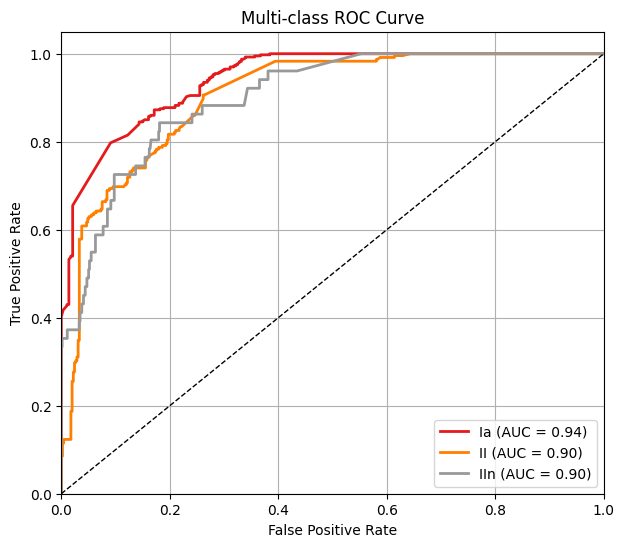

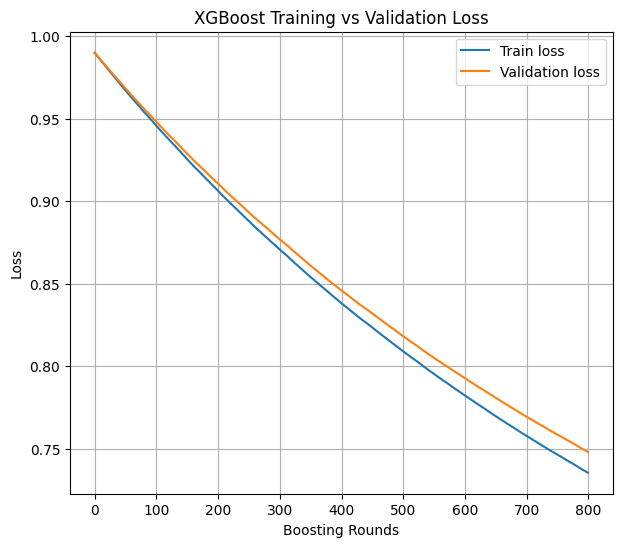

In [103]:
# Model 2 with downsampling
II_bdt_down = XGBClassifier(
    n_estimators=800,
    learning_rate=0.001,
    max_depth=2,
    min_child_weight=3,
    subsample=0.6,
    colsample_bytree=0.6,
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    early_stopping_rounds=5
)

II_bdt_down.fit(II_X_train_down, II_y_train_down,
                eval_set=[(II_X_train_down, II_y_train_down),(II_X_test_down, II_y_test_down)],
                verbose=False)
evaluate_model(II_bdt_down, II_X_train_down, II_y_train_down, II_X_test_down, II_y_test_down, II_labels)

Observation: Model 2 outperforms Model 1 with or without downsampling. Though downsampling seems to make it worse for the classifier, the effect is not as strong as the other two classifiers.

Conclusion:
- Data preprocessing is very important, which in our case is necessary to handle outliers.
- Model 2 outperforms Model 1. Probably because it has more features.
- Boosted decision tree classifier is the most effective, which agrees with the paper.
- Downsampling does not improve classification. The reason might be that our downsampling process results in a too small dataset, making it difficult for the classifiers to learn.
- In Model 2, we did a better job than the paper. Yay 😎!